In [1]:
cd /private/home/ronghanghu/workspace/mmf_nr

/private/home/ronghanghu/workspace/mmf_nr


In [2]:
import os
import numpy as np
import cv2
import torch
import torchvision
import argparse
import omegaconf
import matplotlib.pyplot as plt
import quaternion
from tqdm import tqdm
from skimage import img_as_float
from PIL import Image

from mmf.utils.env import setup_imports
from mmf.utils.configuration import Configuration
from mmf.utils.build import build_config, build_model
from mmf.common.sample import SampleList, Sample


def get_config_from_opts(opts):
    setup_imports()

    args = argparse.Namespace(config_override=None)
    args.opts = opts

    configuration = Configuration(args)
    config = build_config(configuration)
    return config


def load_model(config, device, ckpt_file=None):
    attributes = config.model_config[config.model]
    # Easy way to point to config for other model
    if isinstance(attributes, str):
        attributes = config.model_config[attributes]

    with omegaconf.open_dict(attributes):
        attributes.model = config.model

    model = build_model(attributes)
    model = model.to(device)
    model.eval()

    if ckpt_file is not None:
        state_dict = torch.load(ckpt_file, map_location=device)["model"]
        try:
            model.load_state_dict(state_dict, strict=True)
        except Exception as e:
            print(e)
            print('retry loading with `strict=False`')
            model.load_state_dict(state_dict, strict=False)

    return model


def build_sample_list(img_0, R_0, T_0, R_1, T_1, image_transform):
    sample = Sample()
    sample.orig_img_0 = torch.tensor(img_0)
    sample.trans_img_0 = image_transform(sample.orig_img_0.permute((2, 0, 1)))
    sample.R_0 = torch.tensor(R_0)
    sample.T_0 = torch.tensor(T_0)
    sample.R_1 = torch.tensor(R_1)
    sample.T_1 = torch.tensor(T_1)
    sample_list = SampleList([sample]).to(device)
    return sample_list

In [3]:
exp_name = "realestate10k_dscale2_stride4ft_lowerL1_200"
ckpt_name = "models/model_40000.ckpt"

opts = [
    f"config=projects/neural_rendering/configs/synsin_realestate10k/{exp_name}.yaml",
    f"datasets=synsin_realestate10k",
    f"model=mesh_renderer",
    f"training.batch_size=1",
    f"model_config.mesh_renderer.return_rendering_results_only=True",
]

device = torch.device("cuda:1")
torch.cuda.set_device(device)

ckpt_file = f"./save/synsin_realestate10k/{exp_name}/{ckpt_name}"
assert os.path.exists(ckpt_file)

config = get_config_from_opts(opts)
model = load_model(config, device, ckpt_file)

/private/home/ronghanghu/workspace/mmf_nr/mmf/models/base_model.py:96: UserWarning: No losses are defined in model configuration. You are expected to return loss in your return dict from forward.
  "No losses are defined in model configuration. You are expected "


## Build the data loading

In [4]:
image_size = 256
frame_dir = "/checkpoint/ronghanghu/neural_rendering_datasets/realestate10K/RealEstate10K/all_frames/test/"
# normalize with ResNet-50 preprocessing
image_transform = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
)


def load_image(image_path, W):
    image = img_as_float(
        np.array(Image.open(image_path).resize([W, W], Image.BILINEAR))
    ).astype(np.float32)
    return image


def build_realestate10k_RT_from_txt(intrinsics, extrinsics):
    offset = np.array([[2, 0, -1], [0, -2, 1], [0, 0, -1]], dtype=np.float32)

    intrinsics = np.array(intrinsics, dtype=np.float32).reshape(4)
    extrinsics = np.array(extrinsics, dtype=np.float32).reshape(3, 4)

    origK = np.array(
        [
            [intrinsics[0], 0, intrinsics[2]],
            [0, intrinsics[1], intrinsics[3]],
            [0, 0, 1],
        ],
        dtype=np.float32,
    )
    K = np.matmul(offset, origK)
    P = np.matmul(K, extrinsics)

    # map to PyTorch3d coordinates
    P = P.copy()
    # change from Habitat coordinates to PyTorch3D coordinates
    P[0] *= -1  # flip X axis
    P[2] *= -1  # flip Z axis
    R = P[0:3, 0:3].T  # to row major
    T = P[0:3, 3]
    
    return R, T


def take_pic(img_init, intrinsics, extrinsics_init, extrinsics_new, show=True):
    R_0, T_0 = build_realestate10k_RT_from_txt(intrinsics, extrinsics_init)
    R_1, T_1 = build_realestate10k_RT_from_txt(intrinsics, extrinsics_new)
    sample_list = build_sample_list(
        img_0=img_init,
        R_0=R_0,
        T_0=T_0,
        R_1=R_1,
        T_1=T_1,
        image_transform=image_transform
    ).to(device)

    with torch.no_grad():
        rendering_results = model.forward(sample_list)

    rgba_out = rendering_results['rgba_out_rec_list'][1][0, ..., :3].cpu().numpy()
    rgba_out = np.clip(rgba_out, 0, 1)
    if show:
        plt.figure()
        plt.imshow(rgba_out[..., :3])
    return rgba_out

## Camera transform functions

In [5]:
def extrinsics2RT_orig(extrinsics):
    extrinsics = np.array(extrinsics, dtype=np.float32).reshape(3, 4)

    # map to PyTorch3d coordinates
    P_orig = extrinsics.copy()
    # change from Habitat coordinates to PyTorch3D coordinates
    P_orig[0] *= -1  # flip X axis
    P_orig[2] *= -1  # flip Z axis
    R_orig = P_orig[0:3, 0:3].T  # to row major
    T_orig = P_orig[0:3, 3]
    
    _check_valid_rotation_matrix(R_orig)
    return R_orig, T_orig


def RT_orig2extrinsics(R_orig, T_orig):
    _check_valid_rotation_matrix(R_orig)

    P_orig = np.hstack((R_orig.T, T_orig[..., None]))

    P_orig = P_orig.copy()
    P_orig[0] *= -1  # flip X axis
    P_orig[2] *= -1  # flip Z axis
    extrinsics = P_orig.reshape(-1)
    return extrinsics


def _check_valid_rotation_matrix(R, tol: float = 1e-4):
    """
    Determine if R is a valid rotation matrix by checking it satisfies the
    following conditions:
    ``RR^T = I and det(R) = 1``
    Args:
        R: an (N, 3, 3) matrix
    Returns:
        None
    Emits a warning if R is an invalid rotation matrix.
    """
    eye = np.eye(3)
    orthogonal = np.all(np.abs(R @ R.T - eye) < tol)
    no_distortion = np.abs(np.linalg.det(R) - 1) < tol

    if not (orthogonal and no_distortion):
        raise Exception("R is not a valid rotation matrix")
    return


def _get_habitat_position_rotation(R, T):
    P = np.eye(4, dtype=np.float32)
    P[0:3, 0:3] = R.T
    P[0:3, 3] = T
    
    # change from Habitat coordinates to PyTorch3D coordinates
    P[0] *= -1  # flip X axis
    P[2] *= -1  # flip Z axis
    
    Pinv = np.linalg.inv(P)
    position = Pinv[0:3, 3]
    rotation = Pinv[0:3, 0:3]
    rotation = quaternion.from_rotation_matrix(rotation)
    
    return position, rotation

    
def _get_pytorch3d_camera_RT(position, rotation):
    rotation = quaternion.as_rotation_matrix(rotation)

    Pinv = np.eye(4, dtype=np.float32)
    Pinv[0:3, 0:3] = rotation
    Pinv[0:3, 3] = position
    P = np.linalg.inv(Pinv)

    # change from Habitat coordinates to PyTorch3D coordinates
    P[0] *= -1  # flip X axis
    P[2] *= -1  # flip Z axis

    R = P[0:3, 0:3].T  # to row major
    T = P[0:3, 3]

    return R, T


def _h_rotate_camera(R_in, T_in, degree_right):
    position_in, rotation_in = _get_habitat_position_rotation(R_in, T_in)
    angle = -degree_right * np.pi / 180

    horizontal_rotation = quaternion.from_float_array(
        [np.cos(angle), 0, np.sin(angle), 0]
    )  # wxyz-format
    rotation_out = horizontal_rotation * rotation_in
    R_out, T_out = _get_pytorch3d_camera_RT(position_in, rotation_out)
    return R_out, T_out


def _v_rotate_camera(R_in, T_in, degree_up):
    position_in, rotation_in = _get_habitat_position_rotation(R_in, T_in)
    angle = -degree_up * np.pi / 180

    horizontal_rotation = quaternion.from_float_array(
        [np.cos(angle), np.sin(angle), 0, 0]
    )  # wxyz-format
    rotation_out = horizontal_rotation * rotation_in
    R_out, T_out = _get_pytorch3d_camera_RT(position_in, rotation_out)
    return R_out, T_out


def _move_camera(R_in, T_in, front, up, right, distance):
    position_in, rotation_in = _get_habitat_position_rotation(R_in, T_in)

    # transform direction vector from camera to world
    direction_vec = np.array([right, up, -front], np.float32)
    direction_vec = quaternion.as_rotation_matrix(rotation_in) @ direction_vec

    position_out = position_in + direction_vec * distance
    R_out, T_out = _get_pytorch3d_camera_RT(position_out, rotation_in)
    return R_out, T_out


def _normalize(array):
    return array / np.sqrt(np.sum(array * array))


def _interpolate(ra, rb, theta, t):
    if abs(theta) < 1e-3:
        # the angle is too small, 1 / sin(theta) will be numerically unstable
        return _normalize((1-t) * ra + t * rb)
    else:
        return _normalize((np.sin((1-t) * theta) * ra + np.sin(t * theta) * rb)  / np.sin(theta))


def _interpolate_rotation_quaternion(rotation_a, rotation_b, num):
    # https://stackoverflow.com/questions/4099369/interpolate-between-rotation-matrices
    ra = quaternion.as_float_array(rotation_a)
    rb = quaternion.as_float_array(rotation_b)
    dot = np.dot(ra, rb)
    if dot < 0:
        dot = -dot
        rb = -rb
    dot = np.clip(dot, -1, 1)
    theta = np.arccos(dot)

    interpolated_rotations = [
        quaternion.from_float_array(_interpolate(ra, rb, theta, t))
        for t in np.linspace(0, 1, num)
    ]
    return interpolated_rotations


def _extrapolate_rotation_quaternion(rotation_a, rotation_b, ratio, num):
    # https://stackoverflow.com/questions/4099369/interpolate-between-rotation-matrices
    ra = quaternion.as_float_array(rotation_a)
    rb = quaternion.as_float_array(rotation_b)
    dot = np.dot(ra, rb)
    if dot < 0:
        dot = -dot
        rb = -rb
    dot = np.clip(dot, -1, 1)
    theta = np.arccos(dot)

    interpolated_rotations = [
        quaternion.from_float_array(_interpolate(ra, rb, theta, t))
        for t in np.linspace(1, 1+ratio, num)
    ]
    return interpolated_rotations


def h_rotate(R, T, angles, cameras, sampling=3):
    if not isinstance(angles, list):
        angles = [angles]
    for n, e in enumerate(angles):
        b = angles[n-1] if n > 0 else 0
        for a in np.linspace(b, e,  max(2, int(np.abs(e-b)*sampling))):
            R_new, T_new = _h_rotate_camera(R, T, a)
            cameras.append((R_new, T_new))

    return R_new, T_new


def v_rotate(R, T, angles, cameras, sampling=3):
    if not isinstance(angles, list):
        angles = [angles]
    for n, e in enumerate(angles):
        b = angles[n-1] if n > 0 else 0
        for a in np.linspace(b, e,  max(2, int(np.abs(e-b)*sampling))):
            R_new, T_new = _v_rotate_camera(R, T, a)
            cameras.append((R_new, T_new))

    return R_new, T_new


def move(R, T, distances, FUR_ratios, cameras, sampling=20):
    fwd_ratio, up_ratio, right_ratio = FUR_ratios
    if not isinstance(distances, list):
        distances = [distances]
    for n, e in enumerate(distances):
        b = distances[n-1] if n > 0 else 0
        for d in np.linspace(b, e, max(2, int(np.abs(e-b)*sampling))):
            R_new, T_new = _move_camera(R, T, fwd_ratio, up_ratio, right_ratio, d)
            cameras.append((R_new, T_new))

    return R_new, T_new


def interpolate_RTs(R_a, T_a, R_b, T_b, cameras, num):
    position_a, rotation_a = _get_habitat_position_rotation(R_a, T_a)
    position_b, rotation_b = _get_habitat_position_rotation(R_b, T_b)
    positions = np.linspace(position_a, position_b, num)
    rotations = _interpolate_rotation_quaternion(rotation_a, rotation_b, num)

    Rs, Ts = zip(*(_get_pytorch3d_camera_RT(p, r) for p, r in zip(positions, rotations)))
    for R_new, T_new in zip(Rs, Ts):
        cameras.append((R_new, T_new))

    return R_new, T_new


def extrapolate_RTs(R_a, T_a, R_b, T_b, ratio, cameras, num):
    position_a, rotation_a = _get_habitat_position_rotation(R_a, T_a)
    position_b, rotation_b = _get_habitat_position_rotation(R_b, T_b)
    positions = np.linspace(position_b, position_b + (position_b - position_a) * ratio, num)
    rotations = _extrapolate_rotation_quaternion(rotation_a, rotation_b, ratio, num)

    Rs, Ts = zip(*(_get_pytorch3d_camera_RT(p, r) for p, r in zip(positions, rotations)))
    for R_new, T_new in zip(Rs, Ts):
        cameras.append((R_new, T_new))

    return R_new, T_new


def extrinsics_h_rotate(extrinsics, angles, extrinsics_cameras, sampling=3):
    R, T = extrinsics2RT_orig(extrinsics)
    cameras = []
    h_rotate(R, T, angles, cameras, sampling)
    extrinsics_cameras.extend(RT_orig2extrinsics(r, t) for r, t in cameras)
    return extrinsics_cameras[-1]


def extrinsics_v_rotate(extrinsics, angles, extrinsics_cameras, sampling=3):
    R, T = extrinsics2RT_orig(extrinsics)
    cameras = []
    v_rotate(R, T, angles, cameras, sampling)
    extrinsics_cameras.extend(RT_orig2extrinsics(r, t) for r, t in cameras)
    return extrinsics_cameras[-1]


def extrinsics_move(extrinsics, distances, FUR_ratios, extrinsics_cameras, sampling=20):
    R, T = extrinsics2RT_orig(extrinsics)
    cameras = []
    move(R, T, distances, FUR_ratios, cameras, sampling)
    extrinsics_cameras.extend(RT_orig2extrinsics(r, t) for r, t in cameras)
    return extrinsics_cameras[-1]


def extrinsics_interpolate_RTs(extrinsics_a, extrinsics_b, extrinsics_cameras, num):
    R_a, T_a = extrinsics2RT_orig(extrinsics_a)
    R_b, T_b = extrinsics2RT_orig(extrinsics_b)
    cameras = []
    interpolate_RTs(R_a, T_a, R_b, T_b, cameras, num)
    extrinsics_cameras.extend(RT_orig2extrinsics(r, t) for r, t in cameras)
    return extrinsics_cameras[-1]


def extrinsics_extrapolate_RTs(extrinsics_a, extrinsics_b, ratio, extrinsics_cameras, num):
    R_a, T_a = extrinsics2RT_orig(extrinsics_a)
    R_b, T_b = extrinsics2RT_orig(extrinsics_b)
    cameras = []
    extrapolate_RTs(R_a, T_a, R_b, T_b, ratio, cameras, num)
    extrinsics_cameras.extend(RT_orig2extrinsics(r, t) for r, t in cameras)
    return extrinsics_cameras[-1]

## Select a scene

In [6]:
def load_data_line(data_line):
    data_line = data_line.strip().split()
    intrinsics = np.array(data_line[3:7], dtype=np.float32) / image_size
    extrinsics_src = np.array(data_line[7:19], dtype=np.float32)
    extrinsics_tgt = np.array(data_line[19:31], dtype=np.float32)
    img_src_file = f"{frame_dir}/{data_line[0]}/{data_line[1]}.png"
    img_tgt_file = f"{frame_dir}/{data_line[0]}/{data_line[2]}.png"
    img_src = load_image(img_src_file, image_size)
    img_tgt = load_image(img_tgt_file, image_size)

    return intrinsics, extrinsics_src, extrinsics_tgt, img_src_file, img_tgt_file, img_src, img_tgt

def _snap(show=True):
    take_pic(img_src, intrinsics, extrinsics_src, extrinsics_new, show=show)

/private/home/ronghanghu/workspace/pytorch3d/pytorch3d/transforms/transform3d.py:707: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


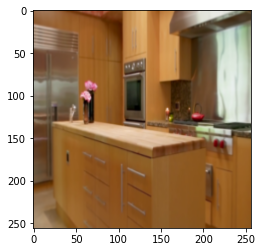

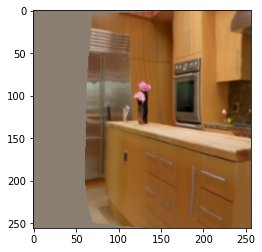

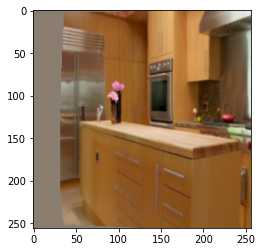

In [7]:
intrinsics, extrinsics_src, extrinsics_tgt, img_src_file, img_tgt_file, img_src, img_tgt = load_data_line("""
002ae53df0e0afe2 62812000 62062000 213.438751 379.446655 128.0 128.0 0.976585 0.027389 -0.21338 -1.11699 -0.02246 0.999423 0.025489 -0.003851 0.213955 -0.020099 0.976637 -0.102793 0.988259 0.020272 -0.151437 -0.933474 -0.016362 0.999501 0.027023 -0.012491 0.151909 -0.024228 0.988097 -0.043311
""")
cameras = []

extrinsics_new = extrinsics_src; _snap()
extrinsics_new = extrinsics_extrapolate_RTs(extrinsics_new, extrinsics_tgt, 1, cameras, num=10); _snap()
extrinsics_new = extrinsics_tgt; _snap()
# ext_new = extrinsics_move(ext_new, 1, (1, 0, 0), cameras); _snap()
# ext_new = extrinsics_h_rotate(ext_new, 2, cameras); _snap()
# ext_new = extrinsics_v_rotate(ext_new, -2, cameras); _snap()